# OOF holography
Te OOF holography computes an aperture distribution model, $\underline{E_\text{a}}(x, y)$, calculates its Fourier transform ($P(u, v)$), and later compares it to an observed power pattern, $P^\text{obs}(u, v)$. The comparison is made by a nonlinear least squares minimization. Once the minimum residual is found, the aperture phase distribution can be computed using the Zernike circle polynomials parametrization (see `aperture.ipynb`).

In [1]:
# Adjustin notebook
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.io import fits, ascii
from scipy.constants import c, golden
import pyoof
from pyoof import aperture, telgeometry

In [3]:
# Plotting parameters, to make it nice :) 
matplotlib.rcParams['figure.figsize'] = (golden * 7, 7)
matplotlib.rcParams['figure.subplot.wspace'] = 0.5
matplotlib.rcParams['figure.subplot.left'] = 0.1
matplotlib.rcParams['figure.subplot.bottom'] = 0.2
matplotlib.rcParams['figure.subplot.right'] = 1
matplotlib.rcParams['figure.subplot.top'] = 0.85
matplotlib.rcParams['axes.labelsize'] = 15
matplotlib.rcParams['axes.titlesize'] = 15

We start with the definitions of the telescope, for ease the Effeslberg telescope will be chosen. It is also possible to change the telescope geometry by changing the blockage distribution, $B(x, y)$, and/or the optical path difference (OPD) function, $\delta(x, y; d_z)$. This is done by using the functions `block_manual` and `opd_manual`.

In [4]:
pr = 50. # primary reflector radius m

# effelsberg_tel = [blockage, delta, pr, name]
effelsberg_telescope=[
    telgeometry.block_effelsberg,
    telgeometry.opd_effelsberg,
    pr,
    'effelsberg'
    ]

The most important parameters to generate data are the illumination coefficients, `I_coeff`, and the Zernike circle polynomials coefficients, `K_coeff`. Some given initial data is also important, such as the frequency of observation (for long wavelength 32 GHz) and the radial offset in meters (of the order of centimeters). Finally telescopes aspects and geometry such as the blockage and OPD, and FFT2 dimensions, `box_factor` and `resolution`.

In [5]:
# Data generator to test pyoof
wavel = 0.0093685143125  # m (32 GHz)
d_z = [-0.022, 0., 0.022]  # radial off set m

n = 5  # initial order
N_K_coeff = (n + 1) * (n + 2) // 2
I_coeff = np.array([1, -14, 0, 0])              # illumination coefficients
K_coeff = np.random.normal(0., .08, N_K_coeff)  # random Zernike circle coeff.

# Generated beam data in a fits file
beam_fits = pyoof.beam_generator(
    params=np.hstack((I_coeff, K_coeff)),
    wavel=wavel,
    d_z=d_z,
    telgeo=effelsberg_telescope[:-1],
    illum_func=aperture.illum_pedestal,
    noise=1e3,
    resolution=2 ** 8,
    box_factor=5
    )

In [6]:
# Extracting the data from the created fits file (on memory)
data_info, data_obs = pyoof.extract_data_pyoof('data_generated/test000.fits')

# this is how the data is stored in the fits file
[name, obs_object, obs_date, pthto, freq, wavel, d_z, meanel] = data_info
[beam_data, u_data, v_data] = data_obs

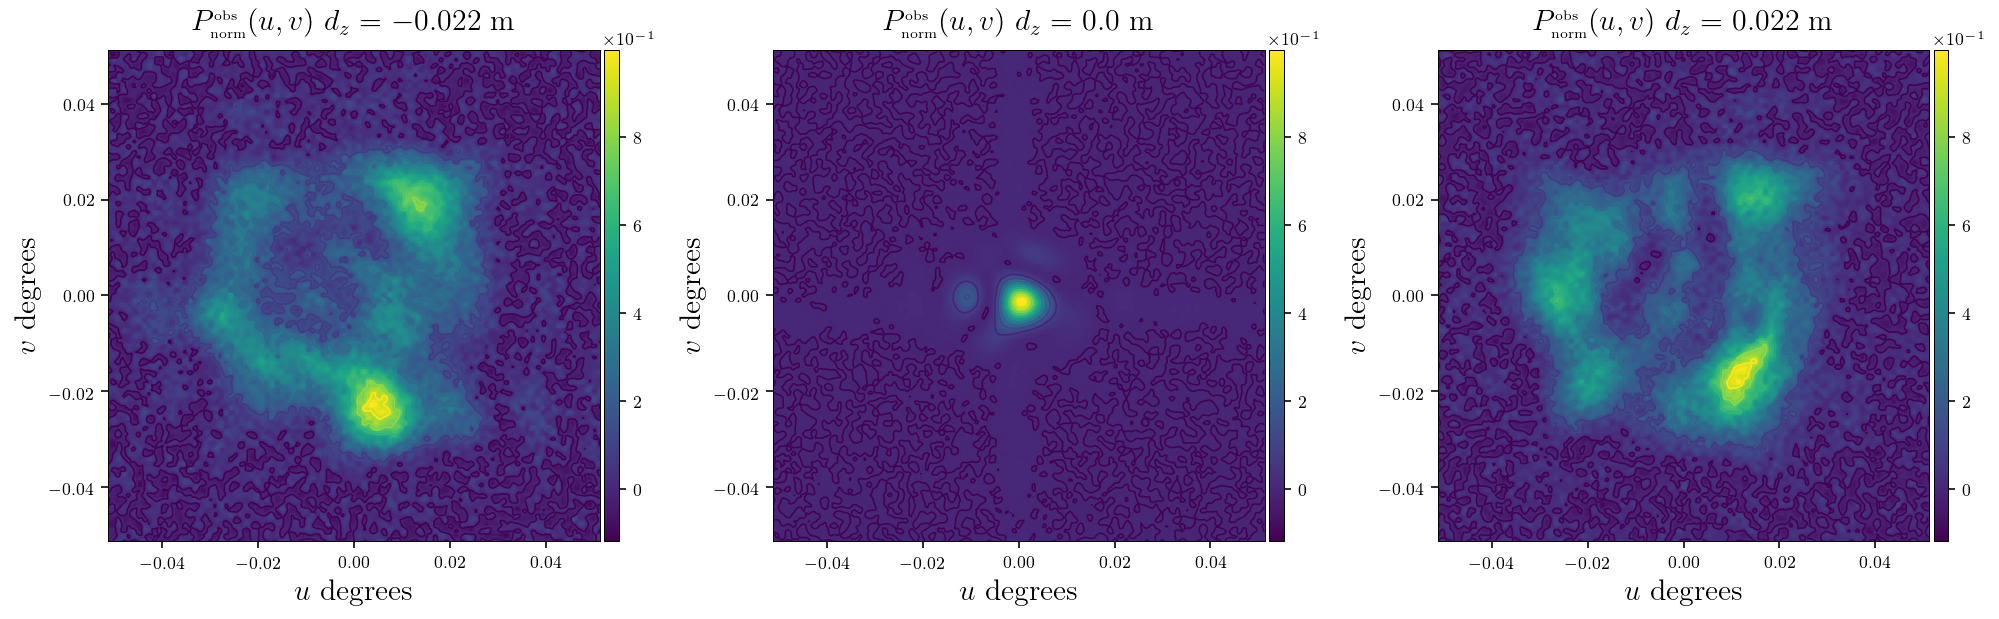

In [7]:
# plotting the generated data
fig = pyoof.plot_data(
    u_data=u_data,
    v_data=v_data,
    beam_data=beam_data,
    d_z=d_z,
    angle='degrees',
    title='',
    res_mode=False
    )

In [8]:
# Core function from the pyoof pacakge :D
pyoof.fit_beam(
    data_info=data_info,                   # Information from the observation
    data_obs=[beam_data, u_data, v_data],  # Observed data
    method='trf',                          # optimization algorithm 'trf', 'lm' or 'dogbox'
    order_max=5,                           # It'll fit from 1 to order_max
    illum_func=aperture.illum_pedestal,    # Illumination function (or illum_gauss)
    telescope=effelsberg_telescope,        # Telescope properties 
    fit_previous=True,                     # True is recommended
    resolution=2 ** 8,                     # Standard is 2 ** 8
    box_factor=5,                          # box_size = 5 * pr, better pixel resolution
    config_params_file=None,               # Default or add path config_file.yaml
    make_plots=True,                       # Stores the plots in sub-directory
    verbose=0                              # to not show process
    )


 ******* PYOOF FIT POWER PATTERN ******* 

... Reading data ... 

Maximum order to be fitted:  5
Telescope name:  effelsberg
File name:  test000
Obs frequency:  32000000000.0 Hz
Obs Wavelength :  0.0094 m
d_z (out-of-focus):  [-0.022  0.     0.022] m
Illumination to be fitted:  pedestal
Initial params: default

 **** PYOOF FIT COMPLETED AT 3.3 mins **** 



Now looking into the created `data_generated/pyoof_out` directory, there are several files from the fit. The `pyoof.beam_generator` routine, creates a file stored in the `data_generated` directory, this is `test000.fit`, if the routine is called again it will make another file `test001.fits`. Same for the `pyoof.fit_beam`, if excecuted twice, then there will be another directory `data_generated/pyoof_out/test000-001`, and so on. Please keep that in mind.

In [9]:
ls data_generated/pyoof_out/test000-000/

beam_data.csv   cov_n3.csv      grad_n1.csv     jac_n4.csv      pyoof_info.yml
corr_n1.csv     cov_n4.csv      grad_n2.csv     jac_n5.csv      res_n1.csv
corr_n2.csv     cov_n5.csv      grad_n3.csv     phase_n1.csv    res_n2.csv
corr_n3.csv     fitpar_n1.csv   grad_n4.csv     phase_n2.csv    res_n3.csv
corr_n4.csv     fitpar_n2.csv   grad_n5.csv     phase_n3.csv    res_n4.csv
corr_n5.csv     fitpar_n3.csv   jac_n1.csv      phase_n4.csv    res_n5.csv
cov_n1.csv      fitpar_n4.csv   jac_n2.csv      phase_n5.csv    u_data.csv
cov_n2.csv      fitpar_n5.csv   jac_n3.csv      plots/          v_data.csv


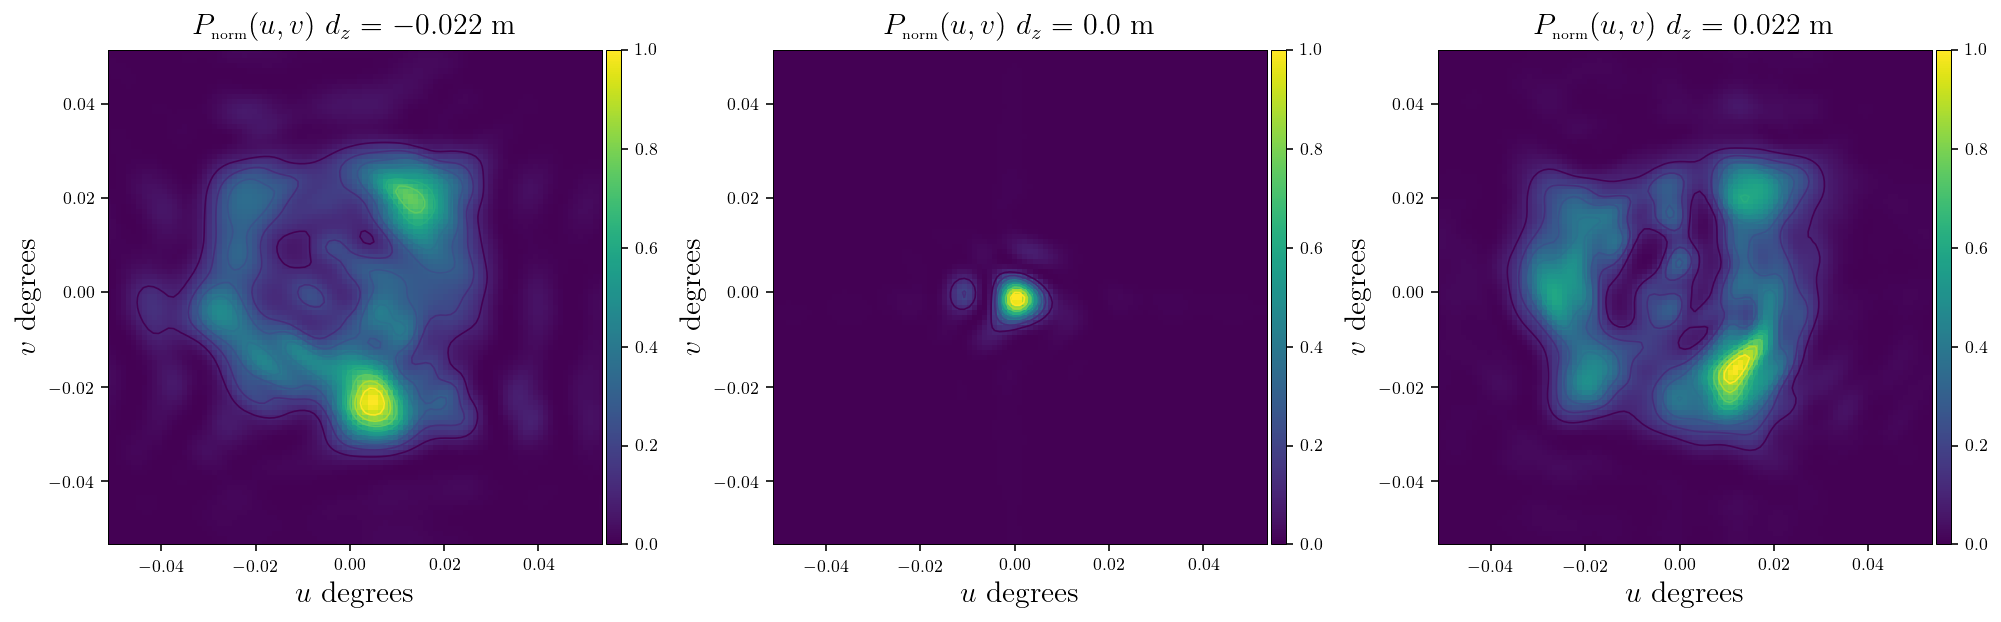

In [10]:
params = ascii.read('data_generated/pyoof_out/test000-000/fitpar_n5.csv')['parfit']

plt.close(fig)
fig = pyoof.plot_beam(
    params=params,
    title='',
    d_z=d_z,
    wavel=wavel,
    illum_func=aperture.illum_pedestal,
    telgeo=effelsberg_telescope[:-1],
    plim_rad=None,
    angle='degrees',
    resolution=2 ** 8,
    box_factor=5
    )

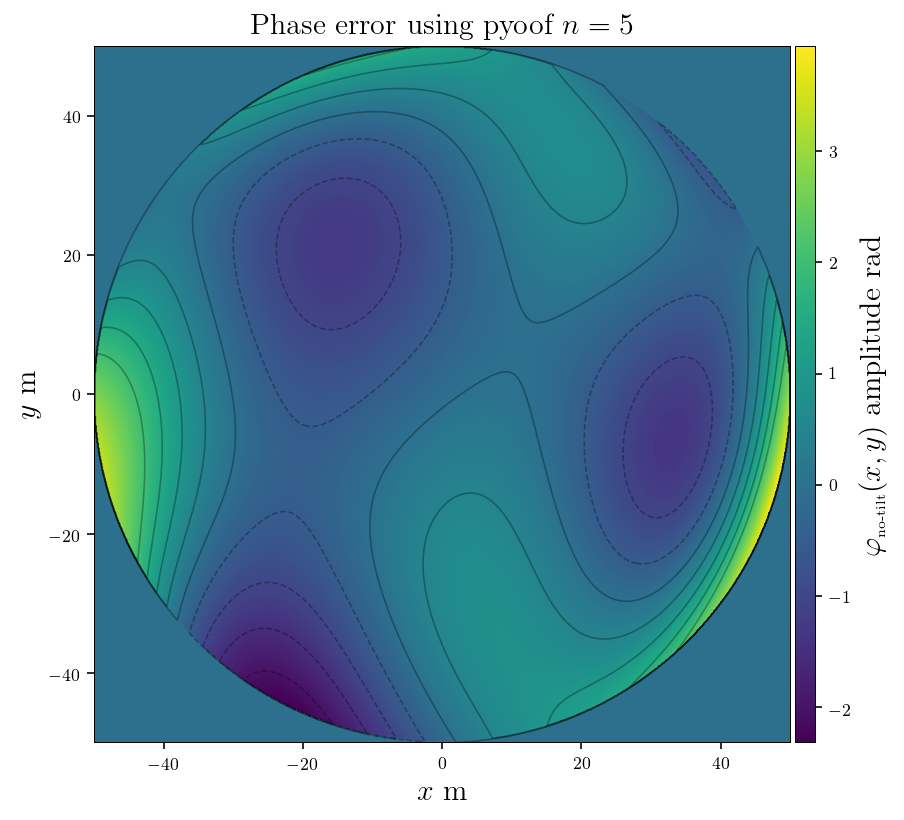

In [11]:
# using the solution from the pyoof
plt.close(fig)
fig1 = pyoof.plot_phase(
    K_coeff=params[4:],
    notilt=True,
    pr=pr,
    title='Phase error using pyoof $n=5$'
    )

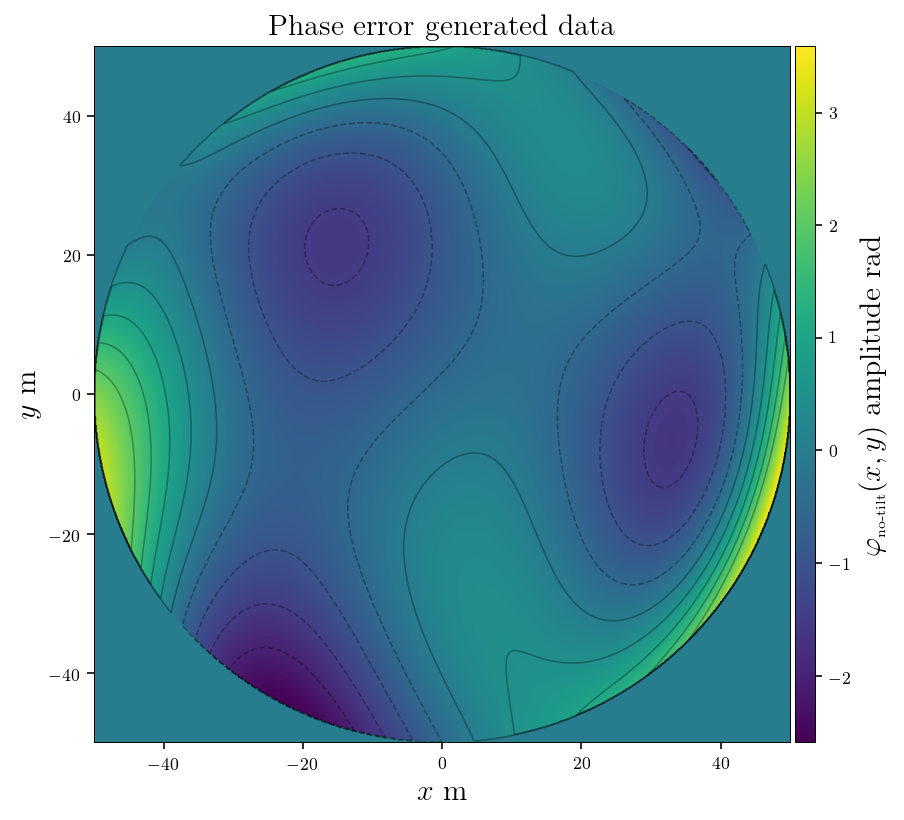

In [12]:
# using the coefficients given to generate data
plt.close(fig1)
fig2 = pyoof.plot_phase(
    K_coeff=K_coeff,
    notilt=True,
    pr=pr,
    title='Phase error generated data'
    )

The above solutions corresponds to the aperture phase distribution, computed with the solution of the `pyoof` package and with the given (random) coefficients to generate data. There is a small difference between the two methods, the user is encourage to test different configurations with different noise level.